In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

print("✓ Bibliotecas importadas!")


✓ Bibliotecas importadas!


In [ ]:
# Carregar dados
df = pd.read_csv('../data/raw/creditcard.csv')

print(f"Dataset carregado: {df.shape}")
print(f"   Fraudes: {df['Class'].sum()} ({df['Class'].mean()*100:.3f}%)")

📊 Dataset carregado: (284807, 31)
   Fraudes: 492 (0.173%)


In [3]:
# Converter Time para formato mais útil
# Time está em segundos desde a primeira transação

# Criar features de tempo
df['Hour'] = (df['Time'] / 3600) % 24  # Hora do dia (0-23)
df['Day'] = (df['Time'] / 86400).astype(int)  # Dia desde início

# Período do dia
def get_time_period(hour):
    if 0 <= hour < 6:
        return 'Madrugada'
    elif 6 <= hour < 12:
        return 'Manhã'
    elif 12 <= hour < 18:
        return 'Tarde'
    else:
        return 'Noite'

df['Time_Period'] = df['Hour'].apply(get_time_period)

print("✓ Features temporais criadas:")
print(f"  - Hour (0-23)")
print(f"  - Day")
print(f"  - Time_Period")


✓ Features temporais criadas:
  - Hour (0-23)
  - Day
  - Time_Period


In [5]:
# Usar apenas uma amostra para visualizações rápidas
df_sample = df.sample(n=50000, random_state=42)  # 50 mil linhas
print(f"✓ Usando amostra de {len(df_sample):,} transações para visualizações")


✓ Usando amostra de 50,000 transações para visualizações


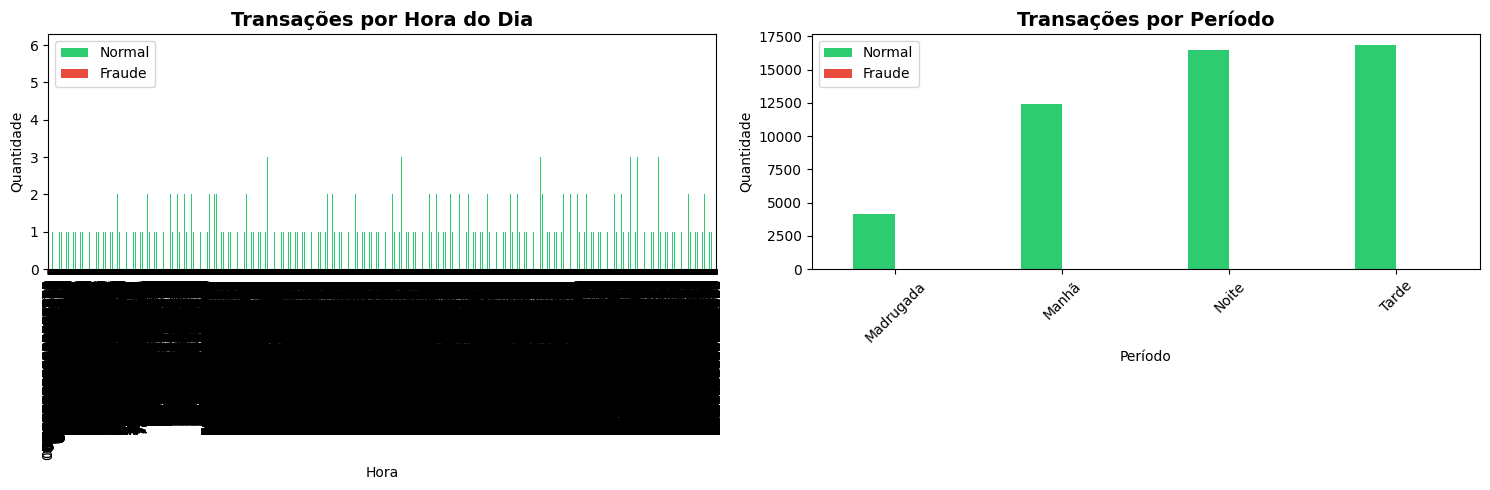

In [15]:
# Visualizar distribuição temporal de fraudes (VERSÃO RÁPIDA)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Por hora - USANDO df_sample
hour_fraud = df_sample.groupby(['Hour', 'Class']).size().unstack()
hour_fraud.plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Transações por Hora do Dia', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Hora')
axes[0].set_ylabel('Quantidade')
axes[0].legend(['Normal', 'Fraude'])

# Por período - USANDO df_sample
period_fraud = df_sample.groupby(['Time_Period', 'Class']).size().unstack()
period_fraud.plot(kind='bar', ax=axes[1], color=['#2ecc71', '#e74c3c'])
axes[1].set_title('Transações por Período', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Período')
axes[1].set_ylabel('Quantidade')
axes[1].legend(['Normal', 'Fraude'])
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [16]:
# Transformações do valor da transação
df['Amount_Log'] = np.log1p(df['Amount'])  # Log transformation
df['Amount_Sqrt'] = np.sqrt(df['Amount'])   # Square root

# Binning de valores
df['Amount_Bin'] = pd.cut(df['Amount'], 
                          bins=[0, 10, 50, 100, 500, float('inf')],
                          labels=['Muito_Baixo', 'Baixo', 'Médio', 'Alto', 'Muito_Alto'])

print("✓ Features de Amount criadas:")
print(f"  - Amount_Log")
print(f"  - Amount_Sqrt")
print(f"  - Amount_Bin")


✓ Features de Amount criadas:
  - Amount_Log
  - Amount_Sqrt
  - Amount_Bin


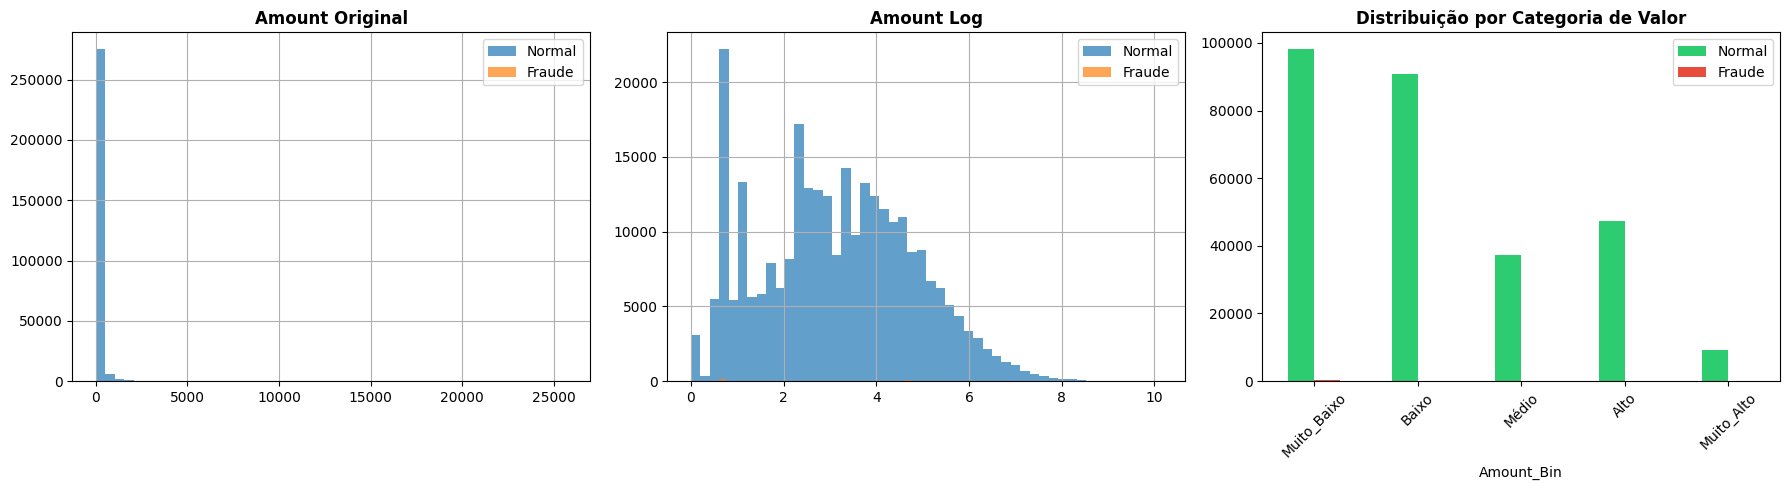

In [17]:
# Visualizar distribuição
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Amount original
df[df['Class']==0]['Amount'].hist(bins=50, ax=axes[0], alpha=0.7, label='Normal')
df[df['Class']==1]['Amount'].hist(bins=50, ax=axes[0], alpha=0.7, label='Fraude')
axes[0].set_title('Amount Original', fontweight='bold')
axes[0].legend()

# Amount Log
df[df['Class']==0]['Amount_Log'].hist(bins=50, ax=axes[1], alpha=0.7, label='Normal')
df[df['Class']==1]['Amount_Log'].hist(bins=50, ax=axes[1], alpha=0.7, label='Fraude')
axes[1].set_title('Amount Log', fontweight='bold')
axes[1].legend()

# Amount por categoria
amount_bin_fraud = df.groupby(['Amount_Bin', 'Class']).size().unstack()
amount_bin_fraud.plot(kind='bar', ax=axes[2], color=['#2ecc71', '#e74c3c'])
axes[2].set_title('Distribuição por Categoria de Valor', fontweight='bold')
axes[2].legend(['Normal', 'Fraude'])
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [20]:
# As features V1-V28 são resultado de PCA

v_cols = [col for col in df.columns if col.startswith('V')]

# Features estatísticas
df['V_mean'] = df[v_cols].mean(axis=1)
df['V_std'] = df[v_cols].std(axis=1)
df['V_min'] = df[v_cols].min(axis=1)
df['V_max'] = df[v_cols].max(axis=1)
df['V_range'] = df['V_max'] - df['V_min']

# Medidas de dispersão
df['V_median'] = df[v_cols].median(axis=1)

# MAD - Substituir por cálculo manual
df['V_mad'] = (df[v_cols].sub(df[v_cols].mean(axis=1), axis=0).abs()).mean(axis=1)

print("✓ Features estatísticas das V criadas:")
print(f"  - V_mean, V_std, V_min, V_max")
print(f"  - V_range, V_median, V_mad")


✓ Features estatísticas das V criadas:
  - V_mean, V_std, V_min, V_max
  - V_range, V_median, V_mad


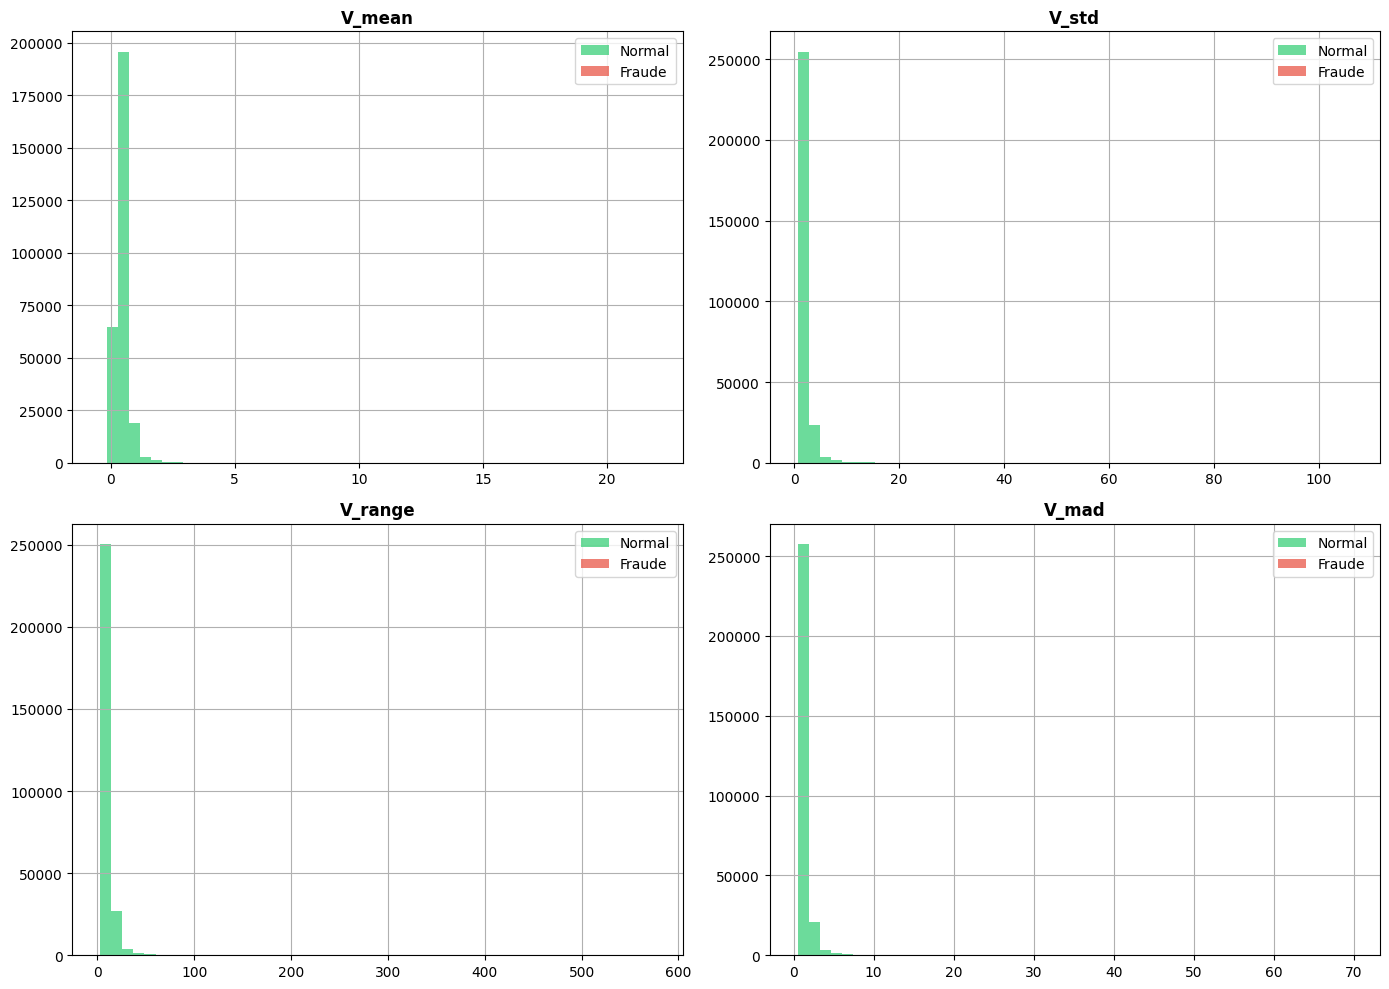

In [21]:
# Comparar estatísticas entre fraude e não-fraude
stats_features = ['V_mean', 'V_std', 'V_range', 'V_mad']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, feature in enumerate(stats_features):
    df[df['Class']==0][feature].hist(bins=50, ax=axes[idx], alpha=0.7, 
                                      label='Normal', color='#2ecc71')
    df[df['Class']==1][feature].hist(bins=50, ax=axes[idx], alpha=0.7, 
                                      label='Fraude', color='#e74c3c')
    axes[idx].set_title(f'{feature}', fontweight='bold')
    axes[idx].legend()

plt.tight_layout()
plt.show()


In [22]:
# Preparar features para modelagem
# Separar features que precisam de scaling

# Features numéricas originais
numerical_features = ['Amount', 'Hour']

# Features criadas
engineered_features = ['Amount_Log', 'Amount_Sqrt', 'V_mean', 'V_std', 
                       'V_min', 'V_max', 'V_range', 'V_median', 'V_mad']

# Features V originais (já estão normalizadas do PCA)
v_features = [col for col in df.columns if col.startswith('V') and len(col) <= 3]

print(f"Total de features para modelagem: {len(numerical_features) + len(engineered_features) + len(v_features)}")


Total de features para modelagem: 39


In [23]:
# Aplicar RobustScaler (melhor para outliers em dados de fraude)
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

# Features que precisam de scaling
features_to_scale = numerical_features + engineered_features

# Criar cópia para não modificar o original
df_scaled = df.copy()

# Aplicar scaling
df_scaled[features_to_scale] = scaler.fit_transform(df[features_to_scale])

print("✓ Scaling aplicado com RobustScaler")
print(f"  Features escaladas: {len(features_to_scale)}")


✓ Scaling aplicado com RobustScaler
  Features escaladas: 11


In [24]:
# One-hot encoding para features categóricas
categorical_features = ['Time_Period', 'Amount_Bin']

df_encoded = pd.get_dummies(df_scaled, columns=categorical_features, 
                            prefix=categorical_features, drop_first=True)

print(f"✓ One-hot encoding aplicado")
print(f"  Shape após encoding: {df_encoded.shape}")
print(f"  Novas colunas: {df_encoded.shape[1] - df_scaled.shape[1]}")


✓ One-hot encoding aplicado
  Shape após encoding: (284807, 49)
  Novas colunas: 5


In [ ]:
# Verificar correlação das novas features com o target
new_features = ['Hour', 'Day', 'Amount_Log', 'Amount_Sqrt', 
                'V_mean', 'V_std', 'V_range', 'V_mad']

correlations = df_encoded[new_features + ['Class']].corr()['Class'].sort_values(ascending=False)

print("Correlação das novas features com fraude:")
print(correlations[1:])  # Excluir a própria Class


🔍 Correlação das novas features com fraude:
V_mad          0.233268
V_std          0.226295
V_range        0.216715
V_mean         0.049195
Amount_Sqrt    0.003140
Day           -0.005223
Amount_Log    -0.008326
Hour          -0.017082
Name: Class, dtype: float64


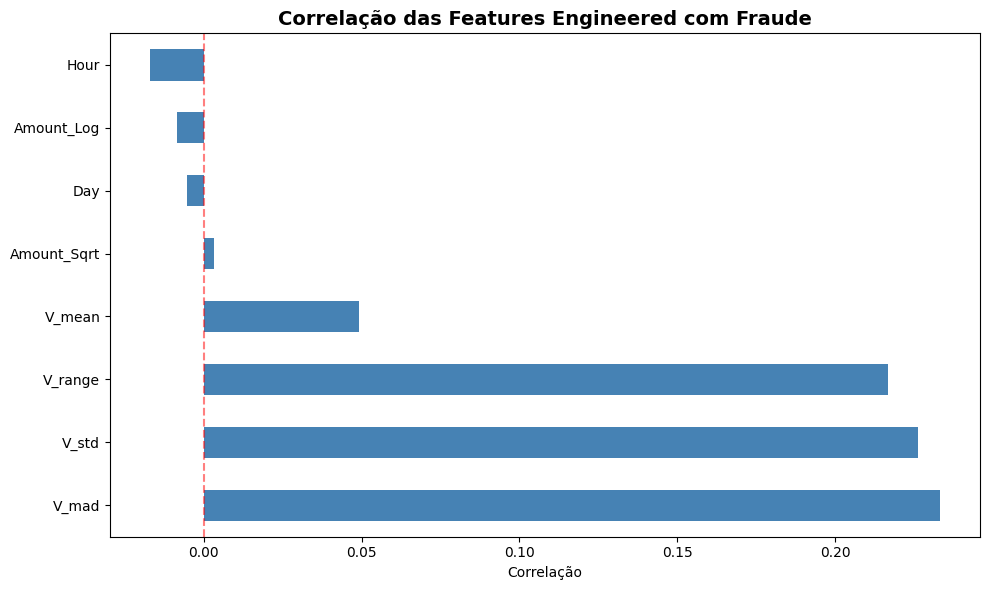

In [26]:
# Visualizar correlações
plt.figure(figsize=(10, 6))
correlations[1:].plot(kind='barh', color='steelblue')
plt.title('Correlação das Features Engineered com Fraude', 
          fontsize=14, fontweight='bold')
plt.xlabel('Correlação')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# Separar features e target
X = df_encoded.drop(['Class', 'Time'], axis=1, errors='ignore')
y = df_encoded['Class']

print(f"Dataset preparado para modelagem:")
print(f"   X shape: {X.shape}")
print(f"   y shape: {y.shape}")
print(f"   Total features: {X.shape[1]}")
print(f"   Fraudes: {y.sum()} ({y.mean()*100:.3f}%)")


✅ Dataset preparado para modelagem:
   X shape: (284807, 47)
   y shape: (284807,)
   Total features: 47
   Fraudes: 492 (0.173%)


In [28]:
# Para detecção de fraude, usar split temporal
# NÃO embaralhar aleatoriamente!

# Ordenar por Time original (se ainda existir)
if 'Time' in df.columns:
    df_sorted = df_encoded.sort_values('Time')
    X = df_sorted.drop(['Class', 'Time'], axis=1, errors='ignore')
    y = df_sorted['Class']

# Split: 80% treino, 20% teste (temporal)
split_index = int(len(X) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print("✓ Split temporal realizado:")
print(f"  Treino: {X_train.shape[0]:,} transações ({y_train.mean()*100:.3f}% fraude)")
print(f"  Teste:  {X_test.shape[0]:,} transações ({y_test.mean()*100:.3f}% fraude)")


✓ Split temporal realizado:
  Treino: 227,845 transações (0.183% fraude)
  Teste:  56,962 transações (0.132% fraude)


In [29]:
# Salvar para próximo notebook
X_train.to_csv('../data/processed/X_train.csv', index=False)
X_test.to_csv('../data/processed/X_test.csv', index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)

print("✓ Dados salvos em data/processed/")


✓ Dados salvos em data/processed/


In [30]:
# Salvar o scaler para usar em produção
import joblib
joblib.dump(scaler, '../models/scaler.pkl')

print("✓ Scaler salvo em models/scaler.pkl")


✓ Scaler salvo em models/scaler.pkl


In [ ]:
print("="*70)
print("RESUMO DO FEATURE ENGINEERING")
print("="*70)

print("\n✅ Features Criadas:")
print(f"  • Features temporais: Hour, Day, Time_Period")
print(f"  • Features de Amount: Amount_Log, Amount_Sqrt, Amount_Bin")
print(f"  • Features estatísticas: V_mean, V_std, V_range, V_mad, etc.")
print(f"  • One-hot encoding aplicado")

print(f"\n📊 Dataset Final:")
print(f"  • Total de features: {X.shape[1]}")
print(f"  • Treino: {X_train.shape[0]:,} amostras")
print(f"  • Teste: {X_test.shape[0]:,} amostras")


print("\n" + "="*70)


RESUMO DO FEATURE ENGINEERING

✅ Features Criadas:
  • Features temporais: Hour, Day, Time_Period
  • Features de Amount: Amount_Log, Amount_Sqrt, Amount_Bin
  • Features estatísticas: V_mean, V_std, V_range, V_mad, etc.
  • One-hot encoding aplicado

📊 Dataset Final:
  • Total de features: 47
  • Treino: 227,845 amostras
  • Teste: 56,962 amostras

